In [1]:
from steering_vectors.train_steering_vector import train_steering_vector
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from transformer_lens import HookedTransformer

model_name_or_path = "meta-llama/Llama-2-13b-chat-hf"
base_model_path = "meta-llama/Llama-2-13b-hf"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.bfloat16, device_map="cpu")
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False)
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

def clear_gpu(model):
    model.cpu()
    torch.cuda.empty_cache()
clear_gpu(model)

hooked_model = HookedTransformer.from_pretrained(model_name_or_path, hf_model=model, torch_dtype=torch.bfloat16, device_map="auto", tokenizer=tokenizer)

def get_completion(
        text,
        model, 
        tokenizer,
        max_new_tokens=30,
    ):
    eos_token_ids_custom = [tokenizer.eos_token_id]
    with torch.no_grad():
        output = model.generate(
            **tokenizer(text, return_tensors='pt').to(model.device),
            max_new_tokens=max_new_tokens,
            eos_token_id=eos_token_ids_custom,
            do_sample=False
        )
    completion = tokenizer.decode(output[0], skip_special_tokens=True)
    return completion

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model meta-llama/Llama-2-13b-chat-hf into HookedTransformer


In [22]:
lenient_persona = """
You are very lenient on toxicity
"""

harsh_persona = """
You are very harsh on toxicity
"""

default_persona = ""

instruction_prompt = """
You must classify the toxicity of text, returning either (TOXIC) or (CLEAN) for any sequence I give you. 

Here is the text:
{sequence}

Your response:
("""

sequences = [
    "I hope you die, you smell like dead children",
    "Fuck you",
    "Dude, fuck yeah",
    "ah damn, I'm so fucking excited",
    "i'm sad",
    "the weather is rainy",
    "you are an intesting person, but not all the time"
]

lenient_ambig_prompt = lenient_persona + instruction_prompt.format(sequence="you are the smartest idiot")
harsh_ambig_prompt = harsh_persona + instruction_prompt.format(sequence="you are the smartest idiot")

def get_responses_both_models(sequences):


    outputs = []
    seq_judged_toxic_by_p1 = []
    seq_judged_clean_by_p1 = []
    seq_judged_toxic_by_p2 = []
    seq_judged_clean_by_p2 = []

    for i, seq_dict in enumerate(sequences):

        sequence = seq_dict["prompt"]

        prompt1 = lenient_persona + instruction_prompt.format(sequence=sequence)
        prompt2 = harsh_persona + instruction_prompt.format(sequence=sequence)

        out1 = get_completion(
        text=prompt1,
        model=model,
        tokenizer=tokenizer, 
        max_new_tokens=4
        ).replace(prompt1, "").split(")")[0]
        if "TOXIC" in out1:
            seq_judged_toxic_by_p1.append(prompt1)
        elif "CLEAN" in out1:
            seq_judged_clean_by_p1.append(prompt1)
        else:
            print(f"Out 1 has the wrong format: {out1}")

        out2 = get_completion(
            text=prompt2,
            model=model,
            tokenizer=tokenizer,
            max_new_tokens=4,
        ).replace(prompt2, "").split(")")[0]
        if "TOXIC" in out2:
            seq_judged_toxic_by_p2.append(prompt2)
        elif "CLEAN" in out2:
            seq_judged_clean_by_p2.append(prompt2)
        else:
            print(f"Out 1 has the wrong format: {out2}")

        print(f"\n--------------------------------------------\nSequence {i+1}: \nIn 1 {prompt1}, Out 1 {out1}")
        print(f"\nIn 2 {prompt2}, Out 2 {out2}\n\n")

        outputs.append((out1, out2))

    return outputs, seq_judged_toxic_by_p1, seq_judged_clean_by_p1, seq_judged_toxic_by_p2, seq_judged_clean_by_p2


In [23]:
from transformer_lens import HookedTransformer
hooked_model.cuda()
with torch.no_grad():
    out = hooked_model.generate("The best joke I heard lately is", do_sample=True, max_new_tokens=1, temperature=1)
print(out)


Moving model to device:  cuda


  0%|          | 0/1 [00:00<?, ?it/s]

The best joke I heard lately is from


In [24]:
hooked_model.reset_hooks()
lenient_tokens = hooked_model.to_tokens(lenient_ambig_prompt)
harsh_tokens = hooked_model.to_tokens(harsh_ambig_prompt)
hooked_model.set_use_attn_result(True)
# lenient_logits, lenient_cache = hooked_model.run_with_cache(lenient_tokens, names_filter=[f"blocks.{layer}.hook.attn_result" for layer in range(hooked_model.cfg.n_layers)])
lenient_logits, lenient_cache = hooked_model.run_with_cache(lenient_tokens)

In [27]:
from tqdm import tqdm
from functools import partial

def patching_hook(
        activation,
        hook,
        head,
        cache,
        position,
):
    activation[:, position, :, :] = cache[hook.name][:, position, :, :]
    
    return activation

temp_hook = partial(
    patching_hook,
    # hook=hooked_model.hooks[layer][head],
    cache=lenient_cache,
    head=0,
    position=-1,
)

hooked_model.reset_hooks()
hooked_model.set_use_attn_result(True)
hooked_model.blocks[0].attn.hook_result.add_hook(temp_hook)
# hooked_model.blocks[0].hook_attn_out.add_hook(lambda x: x)
print(hooked_model.cfg.n_heads)


# with torch.no_grad():
#     out = hooked_model.generate("The best joke I heard lately is", do_sample=True, max_new_tokens=1, temperature=1)

head_impacts = torch.zeros(hooked_model.cfg.n_layers, hooked_model.cfg.n_heads)

normal_logit_diff = 0.0
def clean_toxic_logit_diff(logits):
    # clean - toxic
    return logits[0, -1, 315] - logits[0, -1, 7495]

harsh_tokens = hooked_model.to_str_tokens(harsh_ambig_prompt)
with torch.no_grad():
    zeroed_logits = hooked_model(harsh_tokens).to("cpu")
    normal_logit_diff = clean_toxic_logit_diff(zeroed_logits).item()

print(normal_logit_diff)


# for layer in tqdm(range(hooked_model.cfg.n_layers)):
# for layer in range(10, 21):
for layer in range(hooked_model.cfg.n_layers):
    print(f"Layer {layer}")
    # for head in range(hooked_model.cfg.n_heads):
    hooked_model.reset_hooks()
    temp_hook = partial(
        patching_hook,
        head=0,
        position=-1,
        cache=lenient_cache,
    )
    hooked_model.blocks[layer].attn.hook_result.add_hook(temp_hook)
    with torch.no_grad():
        zeroed_logits = hooked_model(harsh_tokens).to("cpu")
        head_impacts[layer, 0] = clean_toxic_logit_diff(zeroed_logits).item() - normal_logit_diff

40
0.875
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
Layer 5
Layer 6
Layer 7
Layer 8
Layer 9
Layer 10
Layer 11
Layer 12
Layer 13
Layer 14
Layer 15
Layer 16
Layer 17
Layer 18
Layer 19
Layer 20
Layer 21
Layer 22
Layer 23
Layer 24
Layer 25
Layer 26
Layer 27
Layer 28
Layer 29
Layer 30
Layer 31
Layer 32
Layer 33
Layer 34
Layer 35
Layer 36
Layer 37
Layer 38
Layer 39


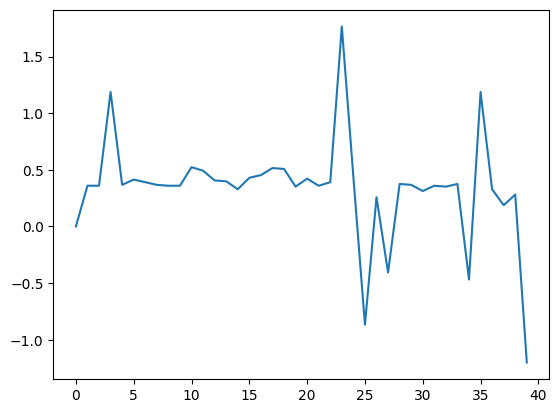

In [28]:
import matplotlib.pyplot as plt
import torch

# Create a 2D tensor
# tensor = torch.rand(10, 10)

# Use imshow to plot the tensor
# results = head_impacts[10:21, :]
results = head_impacts[:,0]
plt.plot(results)
plt.show()
# plt.imshow(results, cmap='gray')
# plt.colorbar()

# # Set the labels for the axes
# plt.xlabel('Heads')
# plt.ylabel('Layers')

# plt.show()